## ALS

In [3]:
! pip install pyspark

Processing /home/faculty/.cache/pip/wheels/84/30/e3/c51c5cd0229631e662d29d7b578a3e5949a4c8db033ffb70aa/pyspark-2.4.5-py2.py3-none-any.whl
  Attempting uninstall: pyspark
    Found existing installation: pyspark 2.4.5
    Uninstalling pyspark-2.4.5:
      Successfully uninstalled pyspark-2.4.5


In [3]:
import numpy as np
import pandas as pd
import time
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

In [2]:
import os
import sys

os.environ['PYSPARK_PYTHON'] = sys.executable
os.environ['PYSPARK_DRIVER_PYTHON'] = sys.executable
import pyspark

number_cores = 4
memory_gb = 16
conf = (
    pyspark.SparkConf()
        .setMaster('local[{}]'.format(number_cores))
        .set('spark.driver.memory', '{}g'.format(memory_gb))
)
sc = pyspark.SparkContext.getOrCreate(conf=conf)
print(sc)

# get the context
spark = pyspark.sql.SparkSession.builder.getOrCreate()
print(spark) 

from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

<SparkContext master=local[4] appName=pyspark-shell>


In [3]:
df = pd.read_table('u.data', sep='\t', header=None, engine = 'python')

In [4]:
df=sqlContext.createDataFrame(df)
df=df.withColumnRenamed('0','user_id')
df=df.withColumnRenamed('1','item_id')
df=df.withColumnRenamed('2','rating')
df=df.withColumnRenamed('3','timestamp')
df.show()

+-------+-------+------+---------+
|user_id|item_id|rating|timestamp|
+-------+-------+------+---------+
|    196|    242|     3|881250949|
|    186|    302|     3|891717742|
|     22|    377|     1|878887116|
|    244|     51|     2|880606923|
|    166|    346|     1|886397596|
|    298|    474|     4|884182806|
|    115|    265|     2|881171488|
|    253|    465|     5|891628467|
|    305|    451|     3|886324817|
|      6|     86|     3|883603013|
|     62|    257|     2|879372434|
|    286|   1014|     5|879781125|
|    200|    222|     5|876042340|
|    210|     40|     3|891035994|
|    224|     29|     3|888104457|
|    303|    785|     3|879485318|
|    122|    387|     5|879270459|
|    194|    274|     2|879539794|
|    291|   1042|     4|874834944|
|    234|   1184|     2|892079237|
+-------+-------+------+---------+
only showing top 20 rows



In [5]:
df.printSchema()

root
 |-- user_id: long (nullable = true)
 |-- item_id: long (nullable = true)
 |-- rating: long (nullable = true)
 |-- timestamp: long (nullable = true)



In [6]:
print((df.count(), len(df.columns)))

(100000, 4)


In [7]:
from pyspark.sql import functions as F
# Calculate average movie rating
df.agg(F.mean('rating')).show()

+-----------+
|avg(rating)|
+-----------+
|    3.52986|
+-----------+



In [8]:
# Test Train Split
df.createOrReplaceTempView('df')
(training, test) = df.randomSplit([0.8, 0.2])
training.printSchema() 
print(training.count())

root
 |-- user_id: long (nullable = true)
 |-- item_id: long (nullable = true)
 |-- rating: long (nullable = true)
 |-- timestamp: long (nullable = true)

79986


In [10]:
# Build the recommendation model using ALS on the training data
als = ALS(userCol="user_id", itemCol="item_id", ratingCol="rating",
         coldStartStrategy="drop", nonnegative = True)

paramGrid = ParamGridBuilder() \
  .addGrid(als.regParam, [0.03,0.1,0.3]) \
  .addGrid(als.maxIter,[3,5,7]) \
  .addGrid(als.rank, [3,10,30]).build()

regEval = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")


tvs = TrainValidationSplit(estimator=als,
                          estimatorParamMaps=paramGrid,
                          evaluator=regEval)

model = tvs.fit(training)

best_model = model.bestModel

# Evaluate the model by computing the RMSE on the test data
predictions = best_model.transform(test)
rmse = regEval.evaluate(predictions)

print("RMSE:"+str(rmse))
print("Rank:", best_model.rank)
print("MaxIter:", best_model._java_obj.parent().getMaxIter())
print("RegParam:", best_model._java_obj.parent().getRegParam())

RMSE:0.9149176765073985
Rank: 30
MaxIter: 7
RegParam: 0.1


## Tensor Flow

In [10]:
# Tensor Flow
from collections import deque
from six import next


import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

In [11]:
print((df.count(), len(df.columns)))

(100000, 4)


In [12]:
ts_df = pd.read_table('u.data', sep='\t', header=None, engine = 'python')
ts_df.rename(columns={0:'user_id',1:'item_id',2:'rating',3:'timestamp'},inplace=True)
ts_df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [13]:
X = ts_df.drop('rating',axis=1)
y = pd.DataFrame(ts_df['rating'])

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [38]:
#! pip install -e git+https://github.com/microsoft/recommenders/#egg=pkg

[Errno 2] No such file or directory: 'Recommenders'
/project


In [15]:
import pyspark

import tensorflow as tf

from reco_utils.common.general_utils import get_number_processors
from reco_utils.common.gpu_utils import get_cuda_version, get_cudnn_version
from reco_utils.dataset.python_splitters import python_stratified_split
warnings.filterwarnings('ignore')

In [16]:
# Constant seed for replicating training results
np.random.seed(42)

u_num = 6040 # Number of users in the dataset
i_num = 3952 # Number of movies in the dataset

batch_size = 1000 # Number of samples per batch
dims = 5          # Dimensions of the data, 15
max_epochs = 50   # Number of times the network sees all the training data

# Device used for all computations
place_device = "/cpu:0"

In [17]:
def get_data():
    ts_df = pd.read_table('u.data', sep='\t', header=None, engine = 'python')
    ts_df.rename(columns={0:'user_id',1:'item_id',2:'rating',3:'timestamp'},inplace=True)
    rows = len(ts_df)
    # Purely integer-location based indexing for selection by position
    ts_df = ts_df.iloc[np.random.permutation(rows)].reset_index(drop=True)
    # Separate data into train and test, 90% for train and 10% for test
    split_index = int(rows * 0.9)
    # Use indices to separate the data
    df_train = ts_df[0:split_index]
    df_test = ts_df[split_index:].reset_index(drop=True)
    
    return df_train, df_test

def clip(x):
    return np.clip(x, 1.0, 5.0)

In [29]:
def model(user_batch, item_batch, user_num, item_num, dim=5, device="/cpu:0"):
    with tf.device("/cpu:0"):
        # Using a global bias term
        bias_global = tf.get_variable("bias_global", shape=[])
        # User and item bias variables
        # get_variable: Prefixes the name with the current variable scope 
        # and performs reuse checks.
        w_bias_user = tf.get_variable("embd_bias_user", shape=[user_num])
        w_bias_item = tf.get_variable("embd_bias_item", shape=[item_num])
        # embedding_lookup: Looks up 'ids' in a list of embedding tensors
        # Bias embeddings for user and items, given a batch
        bias_user = tf.nn.embedding_lookup(w_bias_user, user_batch, name="bias_user")
        bias_item = tf.nn.embedding_lookup(w_bias_item, item_batch, name="bias_item")
        # User and item weight variables
        w_user = tf.get_variable("embd_user", shape=[user_num, dim],
                                 initializer=tf.truncated_normal_initializer(stddev=0.02))
        w_item = tf.get_variable("embd_item", shape=[item_num, dim],
                                 initializer=tf.truncated_normal_initializer(stddev=0.02))
        # Weight embeddings for user and items, given a batch
        embd_user = tf.nn.embedding_lookup(w_user, user_batch, name="embedding_user")
        embd_item = tf.nn.embedding_lookup(w_item, item_batch, name="embedding_item")
    
    with tf.device(device):
        # reduce_sum: Computes the sum of elements across dimensions of a tensor
        infer = tf.reduce_sum(tf.multiply(embd_user, embd_item), 1)
        infer = tf.add(infer, bias_global)
        infer = tf.add(infer, bias_user)
        infer = tf.add(infer, bias_item, name="svd_inference")
        # l2_loss: Computes half the L2 norm of a tensor without the sqrt
        regularizer = tf.add(tf.nn.l2_loss(embd_user), tf.nn.l2_loss(embd_item), 
                             name="svd_regularizer")
    return infer, regularizer

In [30]:
def loss(infer, regularizer, rate_batch, learning_rate=0.1, reg=0.1, device="/cpu:0"):
    with tf.device(device):
        # Use L2 loss to compute penalty
        cost_l2 = tf.nn.l2_loss(tf.subtract(infer, rate_batch))
        penalty = tf.constant(reg, dtype=tf.float32, shape=[], name="l2")
        cost = tf.add(cost_l2, tf.multiply(regularizer, penalty))
        # 'Follow the Regularized Leader' optimizer
        # Reference: http://www.eecs.tufts.edu/~dsculley/papers/ad-click-prediction.pdf
        train_op = tf.train.FtrlOptimizer(learning_rate).minimize(cost)
    return cost, train_op

In [27]:
df_train, df_test = get_data()

samples_per_batch = len(df_train) // batch_size
print("Number of train samples %d, test samples %d, samples per batch %d" % 
      (len(df_train), len(df_test), samples_per_batch))

Number of train samples 90000, test samples 10000, samples per batch 90


In [21]:
print(df_train["user_id"].head()) 
print(df_test["user_id"].head())

0    877
1    815
2     94
3    416
4    500
Name: user_id, dtype: int64
0    655
1    178
2    873
3     10
4    325
Name: user_id, dtype: int64


In [22]:
print(df_train["item_id"].head())
print(df_test["item_id"].head())

0    381
1    602
2    431
3    875
4    182
Name: item_id, dtype: int64
0    271
1     83
2    294
3    116
4    305
Name: item_id, dtype: int64


In [ ]:
hello = tf.constant('Hello, TensorFlow!')
sess = tf.Session()

In [ ]:
print(sess.run(hello))

In [23]:
import readers

In [31]:
# Using a shuffle iterator to generate random batches, for training
iter_train = readers.ShuffleIterator([df_train["user_id"],
                                     df_train["item_id"],
                                     df_train["rating"]],
                                     batch_size=batch_size)

# Sequentially generate one-epoch batches, for testing
iter_test = readers.OneEpochIterator([df_test["user_id"],
                                     df_test["item_id"],
                                     df_test["rating"]],
                                     batch_size=-1)



In [32]:

user_batch = tf.placeholder(tf.int32, shape=[None], name="id_user")
item_batch = tf.placeholder(tf.int32, shape=[None], name="id_item")
rate_batch = tf.placeholder(tf.float32, shape=[None])

infer, regularizer = model(user_batch, item_batch, user_num=u_num, item_num=i_num, dim=dims, device=place_device)
_, train_op = loss(infer, regularizer, rate_batch, learning_rate=0.10, reg=0.05, device=place_device)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [41]:
saver = tf.train.Saver()
init_op = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init_op)
    print("%s\t%s\t%s\t%s" %("Epoch", "Train Error", "Val Error", "Elapsed Time"))
    errors = deque(maxlen=samples_per_batch)
    start = time.time()
    for i in range(max_epochs*samples_per_batch):
        users, items, rates = next(iter_train)
        _, pred_batch = sess.run([train_op, infer], feed_dict={user_batch : users,
                                                               item_batch : items, 
                                                               rate_batch : rates})
        pred_batch = clip(pred_batch)
        errors.append(np.power(pred_batch - rates,2))
        if i % samples_per_batch == 0:
            train_err = np.sqrt(np.mean(errors))
            test_err2 = np.array([])
            for users, items, rates in iter_test:
                pred_batch = sess.run(infer, feed_dict={user_batch : users,
                                                        item_batch : items})
                pred_batch = clip(pred_batch)
                test_err2 = np.append(test_err2, np.power(pred_batch - rates, 2))
            end = time.time()
            print("%02d\t%.3f\t\t%.3f\t\t%.3f secs" % (i // samples_per_batch, train_err, np.sqrt(np.mean(test_err2)), end - start))
            start = end

    saver.save(sess, './save/model')

Epoch	Train Error	Val Error	Elapsed Time
00	2.376		2.167		0.065 secs
01	1.140		0.960		0.103 secs
02	0.917		0.937		0.097 secs
03	0.892		0.925		0.094 secs
04	0.874		0.919		0.097 secs
05	0.861		0.914		0.096 secs
06	0.855		0.911		0.097 secs
07	0.854		0.910		0.097 secs
08	0.844		0.907		0.095 secs
09	0.839		0.907		0.094 secs
10	0.840		0.906		0.096 secs
11	0.834		0.905		0.095 secs
12	0.826		0.905		0.095 secs
13	0.826		0.904		0.094 secs
14	0.824		0.904		0.096 secs
15	0.817		0.904		0.095 secs
16	0.817		0.904		0.092 secs
17	0.815		0.904		0.097 secs
18	0.814		0.904		0.095 secs
19	0.814		0.904		0.093 secs
20	0.811		0.904		0.096 secs
21	0.809		0.905		0.095 secs
22	0.805		0.905		0.094 secs
23	0.809		0.904		0.098 secs
24	0.803		0.904		0.093 secs
25	0.806		0.904		0.096 secs
26	0.804		0.905		0.094 secs
27	0.800		0.905		0.093 secs
28	0.803		0.905		0.096 secs
29	0.800		0.906		0.096 secs
30	0.799		0.906		0.094 secs
31	0.801		0.906		0.098 secs
32	0.798		0.906		0.095 secs
33	0.793		0.906		0.096 secs
34	0.79

In [42]:
init_op = tf.global_variables_initializer()

with tf.Session() as sess:
    #sess.run(init_op)
    new_saver = tf.train.import_meta_graph('./save/model.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('./save/'))
    test_err2 = np.array([])
    for users, items, rates in iter_test:
        pred_batch = sess.run(infer, feed_dict={user_batch: users,
                                                item_batch: items})
        pred_batch = clip(pred_batch)
        print("Pred\tActual")
        for ii in range(10):
            print("%.3f\t%.3f" % (pred_batch[ii], rates[ii]))
        test_err2 = np.append(test_err2, np.power(pred_batch - rates, 2))
        print("RMSE:",np.sqrt(np.mean(test_err2)))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./save/model
Pred	Actual
2.426	3.000
3.389	5.000
3.669	3.000
3.693	4.000
4.372	5.000
3.950	5.000
2.730	2.000
3.791	4.000
3.387	3.000
3.750	5.000
0.9071531696822109


## Neural Network

In [1]:
! pip install keras

In [3]:
import numpy as np
import pandas as pd
from keras.layers import Embedding, Reshape, Dropout, Dense, merge, Input, Flatten, Concatenate, Dot, Add, Activation
from keras.models import Sequential
from keras.models import Model
from keras.optimizers import SGD
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
import math
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda/envs/Python3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda/envs/Python3/lib/python3.6/sit

In [5]:
# Load data
nn_df = pd.read_table('u.data', sep='\t', header=None, engine = 'python')
nn_df.rename(columns={0:'user_id',1:'item_id',2:'rating',3:'timestamp'},inplace=True)
num_users = nn_df['user_id'].max()
num_items = nn_df['item_id'].max()
nn_df = nn_df.drop('timestamp', 1)
nn_df.head()

,user_id,item_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


In [6]:
# Shuffling data
shuffled_df = nn_df.sample(frac=1., random_state=42)
users = shuffled_df['user_id'].values
items = shuffled_df['item_id'].values
ratings = shuffled_df['rating'].values

In [7]:
users = users.astype('float')
items = items.astype('float')
ratings = ratings.astype('float')

In [8]:
N = shuffled_df.user_id.max() + 1 # number of users
M = shuffled_df.item_id.max() + 1 # number of movies

# initialize variables
K = 10 # latent dimensionality
mu = shuffled_df.rating.mean()
epochs = 15
reg = 0. # regularization penalty

# keras model
u = Input(shape=(1,))
m = Input(shape=(1,))
u_embedding = Embedding(N, K)(u) # (N, 1, K)
m_embedding = Embedding(M, K)(m) # (N, 1, K)

# main branch
u_bias = Embedding(N, 1)(u) # (N, 1, 1)
m_bias = Embedding(M, 1)(m) # (N, 1, 1)
x = Dot(axes=2)([u_embedding, m_embedding]) # (N, 1, 1)
x = Add()([x, u_bias, m_bias])
x = Flatten()(x) # (N, 1)

# side branch
u_embedding = Flatten()(u_embedding) # (N, K)
m_embedding = Flatten()(m_embedding) # (N, K)
y = Concatenate()([u_embedding, m_embedding]) # (N, 2K)
y = Dense(400)(y)
y = Activation('elu')(y)
# y = Dropout(0.5)(y)
y = Dense(1)(y)

In [9]:
# merge
x = Add()([x, y])

model = Model(inputs=[u, m], outputs=x)
model.compile(
  loss='mse',
  # optimizer='adam',
  # optimizer=Adam(lr=0.01),
  optimizer=SGD(lr=0.08, momentum=0.9),
  metrics=['mse'],)
r = model.fit(
  x=[users, items],y=ratings - mu,
  epochs=epochs,
  batch_size=150,
  validation_split=.1)


Train on 90000 samples, validate on 10000 samples
Epoch 1/15
90000/90000 [==============================] - 1s 14us/step - loss: 0.9910 - mse: 0.9910 - val_loss: 0.9301 - val_mse: 0.9301
Epoch 2/15
90000/90000 [==============================] - 1s 11us/step - loss: 0.8912 - mse: 0.8912 - val_loss: 0.8949 - val_mse: 0.8949
Epoch 3/15
90000/90000 [==============================] - 1s 11us/step - loss: 0.8721 - mse: 0.8721 - val_loss: 0.8906 - val_mse: 0.8906
Epoch 4/15
90000/90000 [==============================] - 1s 11us/step - loss: 0.8589 - mse: 0.8589 - val_loss: 0.8976 - val_mse: 0.8976
Epoch 5/15
90000/90000 [==============================] - 1s 11us/step - loss: 0.8449 - mse: 0.8449 - val_loss: 0.8917 - val_mse: 0.8917
Epoch 6/15
90000/90000 [==============================] - 1s 11us/step - loss: 0.8328 - mse: 0.8328 - val_loss: 0.8670 - val_mse: 0.8670
Epoch 7/15
90000/90000 [==============================] - 1s 11us/step - loss: 0.8205 - mse: 0.8205 - val_loss: 0.8626 - val_ms

In [12]:
r.history.keys()

dict_keys(['val_loss', 'val_mse', 'loss', 'mse'])

In [11]:
print('MSE:{:.3f}'.format(np.mean(r.history['mse'])))

MSE:0.816


(0.0, 3.0)

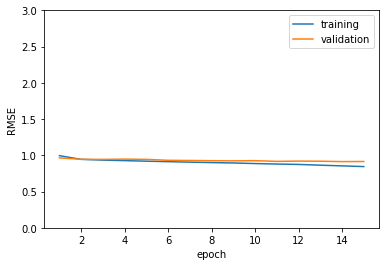

In [10]:
results = pd.DataFrame({'epoch': [ i + 1 for i in r.epoch ],
                     'training': [ math.sqrt(loss) for loss in r.history['loss'] ],
                     'validation': [ math.sqrt(loss) for loss in r.history['val_loss'] ]})
ax = results.iloc[:,:].plot(x='epoch')
ax.set_ylabel("RMSE")
ax.set_ylim([0.0,3.0])